In [9]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Read the data and show basic statistics

In [6]:
df = pd.read_csv("data/finnhub2h.csv")
columns = ["price", "volume", "trade_ts"]
timestamp_format = "%Y-%m-%d %H:%M:%S.%f%z"

df = df[columns]
df["trade_ts"] = df["trade_ts"].apply(lambda x: datetime.strptime(x, timestamp_format))
df = df.set_index("trade_ts")

size_of_df = len(df)
df.describe()

,price,volume
count,58419.00000,58419.000000
mean,101381.63425,0.016505
std,356.57938,0.068510
min,100530.07000,0.000010
25%,101110.26000,0.000240
50%,101428.01000,0.000980
75%,101700.00000,0.005990
max,101898.00000,6.602400


In [31]:
print(df.index.to_series().diff().value_counts())

trade_ts
0 days 00:00:00.001000    6433
0 days 00:00:00.002000    4388
0 days 00:00:00.003000    2823
0 days 00:00:00.004000    2037
0 days 00:00:00.005000    1656
                          ... 
0 days 00:00:00.936000       1
0 days 00:00:01.094000       1
0 days 00:00:00.683000       1
0 days 00:00:01.269000       1
0 days 00:00:01.507000       1
Name: count, Length: 1005, dtype: int64


<Axes: title={'center': '1-Second Average'}, xlabel='trade_ts'>

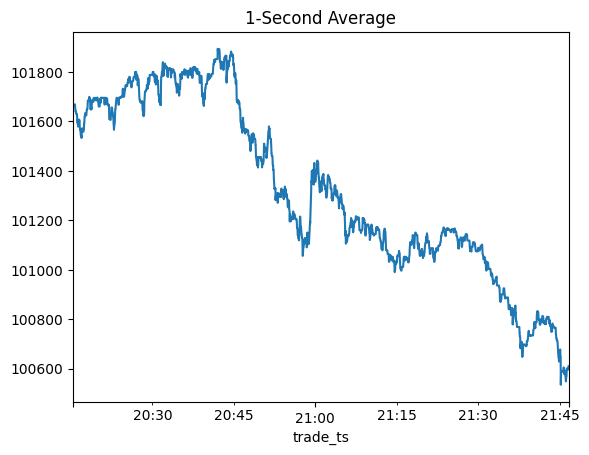

In [34]:
df['price'].resample('1s').mean().plot(title='1-Second Average')

<Axes: title={'center': '1-Minute Average'}, xlabel='trade_ts'>

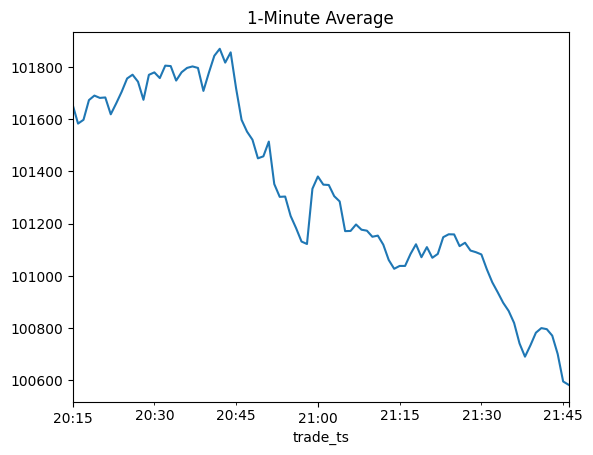

In [35]:
df['price'].resample('1Min').mean().plot(title='1-Minute Average')

# Visualization
## Line Plot for prices & histogram for volume

C:\Users\seksc\Documents\sem7\anomaly-detection\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


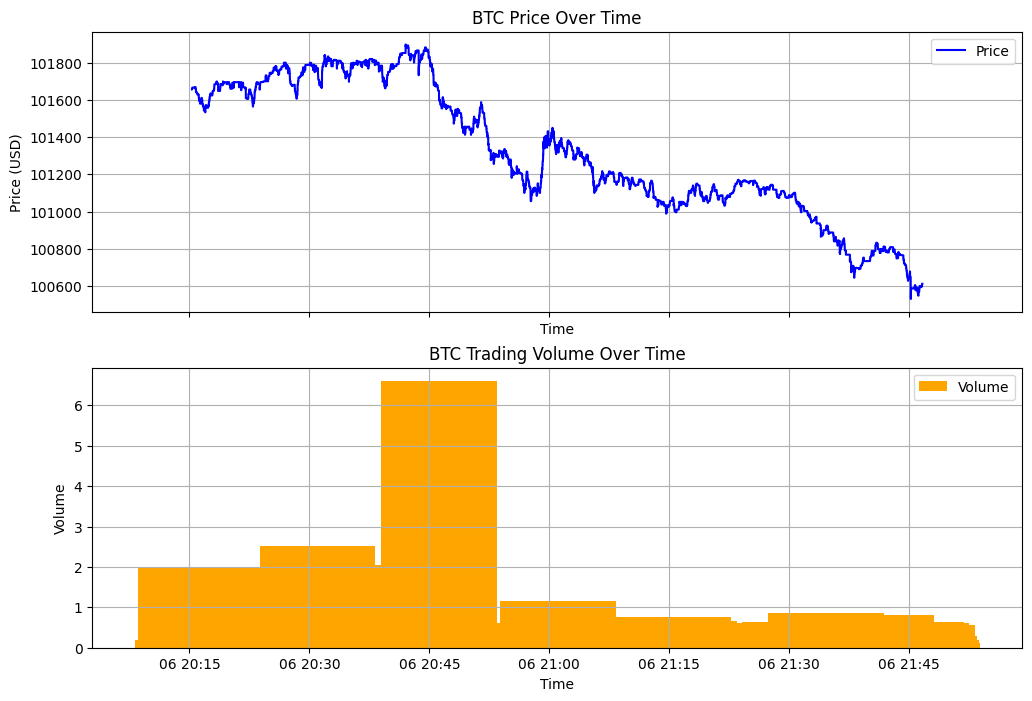

In [7]:
# Plot Price and Volume
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Price
ax[0].plot(df.index, df["price"], label="Price", color="blue", linewidth=1.5)
ax[0].set_title("BTC Price Over Time")
ax[0].set_ylabel("Price (USD)")
ax[0].set_xlabel("Time")
ax[0].grid(True)
ax[0].legend()

# Plot Volume
ax[1].bar(df.index, df["volume"], label="Volume", color="orange", width=0.01)
ax[1].set_title("BTC Trading Volume Over Time")
ax[1].set_ylabel("Volume")
ax[1].set_xlabel("Time")
ax[1].grid(True)
ax[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Box plot

<Axes: xlabel='trade_ts', ylabel='price'>

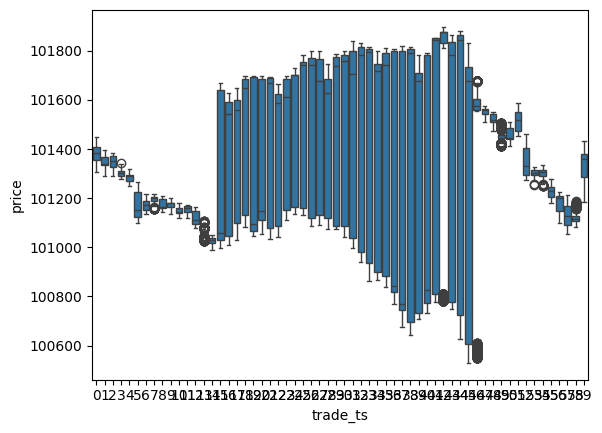

In [14]:
sns.boxplot(x=df.index.minute, y="price", data=df)

# Autocorrelation Plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

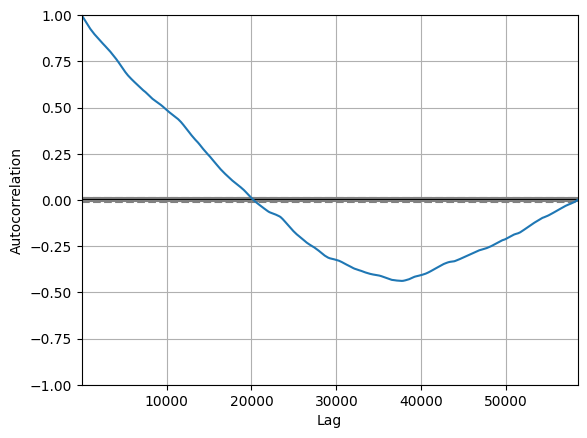

In [15]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df["price"])

1. This plot does not show any recurring peaks or cycles, so the series is likely non-periodic.
2. 

In [30]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['price'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: 0.15708799063161788
p-value: 0.9697494442308232


<p>p-value is greater than 0.05 so the null hypothesis cannot be rejected, and the time series is considered <b>non-stationary</b></p>


# Decomposition so Trend, Seasonality and Residuals

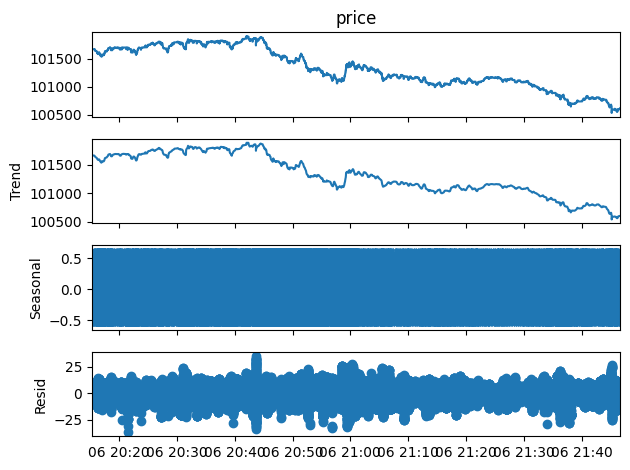

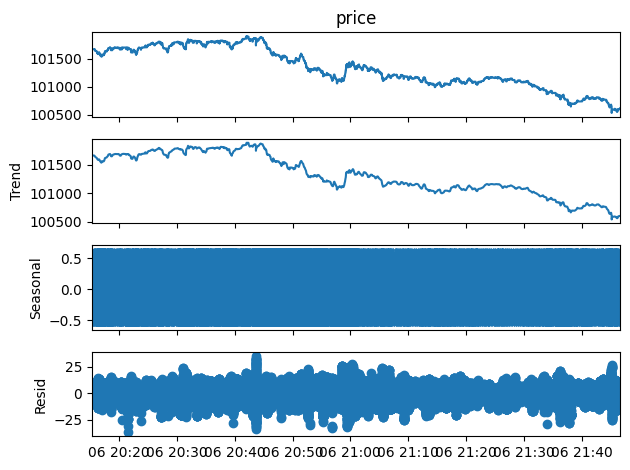

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df["price"], model="additive", period=120)
result.plot()

<Axes: xlabel='trade_ts'>

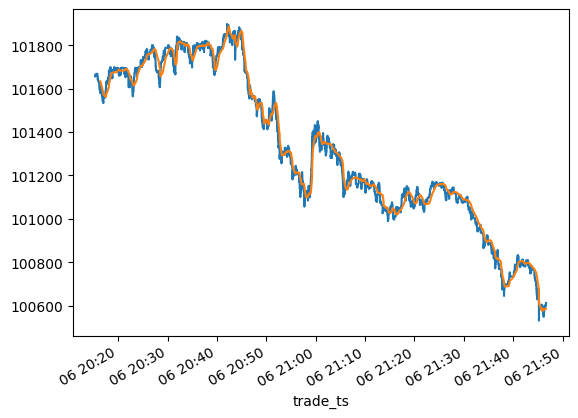

In [24]:
df["rolling_mean"] = df["price"].rolling(window=512).mean()
df["price"].plot()
df["rolling_mean"].plot()

In [28]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(df['price']).fit(smoothing_level=0.2)
df['smoothed'] = model.fittedvalues

C:\Users\seksc\Documents\sem7\anomaly-detection\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\seksc\Documents\sem7\anomaly-detection\.venv\lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [27]:
df[["price", "volume"]].corr()

,price,volume
price,1.000000,0.004915
volume,0.004915,1.000000
